In [10]:
import requests
import pandas as pd

# set variables - begin
key = "KewMkAROhJp3WFV-vo2I"
email = "rafael.machado@bts.tech"
start_date = "2024-11-01"
end_date = "2024-11-30"
# set variables - end

#per_page = 5000 - API default/fixed value, can't be changed
page = 1
df = pd.DataFrame()

while True:
        
    # API endpoint and parameters
    url = "https://api.acleddata.com/acled/read"
    params = {
        "key": key,
        "email": email,
        "page": page,
        "event_date": start_date+"|"+end_date,
        "event_date_where": "BETWEEN"
    }

    # Make the API request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract the status attribute as the response.status_code do not cover all error messages
        if data["status"] != 200:
            print("API request failed with status code "+str(data["status"])+": "+response.text)
            break
        
        # Extract the data attribute 
        if "data" in data:
            results = data["data"]
            
            # Convert the results array into a DataFrame
            df_paging = pd.DataFrame(results)

            # Break the loop if no items are returned
            if len(df_paging) == 0:
                break

            dtype_dict = {
                "event_id_cnty": "string",
                "event_date": "datetime64[ns]",
                "year": "int",
                "time_precision": "int",
                "disorder_type": "string",
                "event_type": "string",
                "sub_event_type": "string",
                "actor1": "string",
                "assoc_actor_1": "string",
                "inter1": "string",
                "actor2": "string",
                "assoc_actor_2": "string",
                "inter2": "string",
                "interaction": "string",
                "civilian_targeting": "string",
                "iso": "int",
                "region": "string",
                "country": "string",
                "admin1": "string",
                "admin2": "string",
                "admin3": "string",
                "location": "string",
                "latitude": "float", 
                "longitude": "float",
                "geo_precision": "int",
                "source": "string",
                "source_scale": "string",
                "notes": "string",
                "fatalities": "int",
                "tags": "string",
                "timestamp": "string",
            }
            
            # convert df data types into data dictionary types
            df_paging = df_paging.astype(dtype_dict)

            # merge df pagings
            df = pd.concat([df, df_paging], ignore_index=True)

            print("page: "+str(page)+" - number of rows: "+str(len(df_paging)))

        else:
            print("The 'data' attribute was not found in the response.")
            break
    else:
        print("API request failed with status code {response.status_code}: {response.text}")
        break

    # Move to the next page
    page += 1

print("Total number of rows in the dataframe: "+str(len(df)))

page: 1 - number of rows: 5000
page: 2 - number of rows: 5000
page: 3 - number of rows: 5000
page: 4 - number of rows: 5000
page: 5 - number of rows: 5000
page: 6 - number of rows: 5000
page: 7 - number of rows: 1867
Total number of rows in the dataframe: 31867


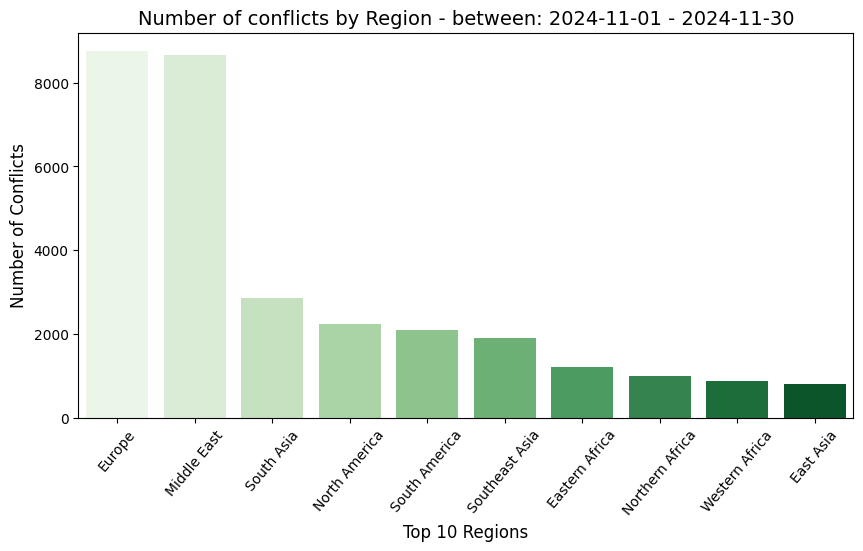

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

region_totals =  df.groupby(['region']).size().sort_values(ascending=False).reset_index(name='count') 
region_totals = region_totals.nlargest(10, 'count')

# Plot number of conflicts per region
plt.figure(figsize=(10, 5))
sns.barplot(x="region", y="count", data=region_totals, palette="Greens", hue='region', legend=False)
plt.title("Number of conflicts by Region - between: "+start_date+" - "+end_date, fontsize=14)
plt.ylabel("Number of Conflicts", fontsize=12)
plt.xlabel("Top 10 Regions", fontsize=12)
plt.xticks(rotation = 50)
plt.show()

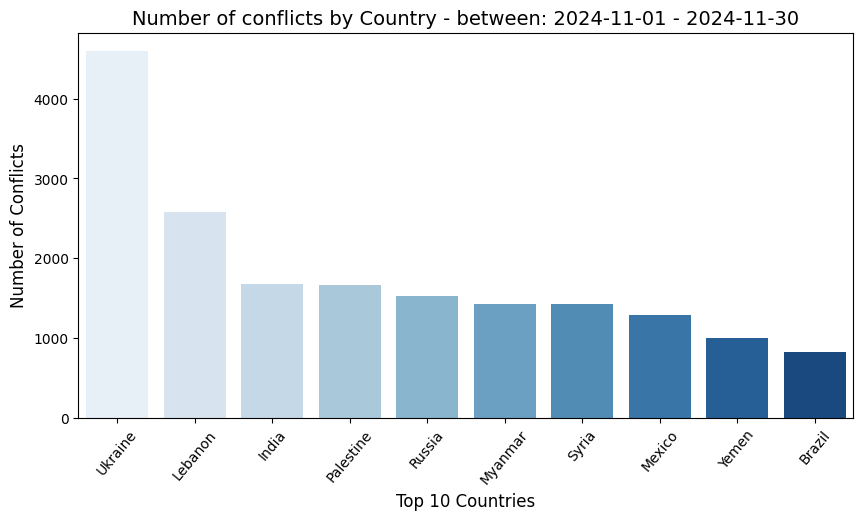

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

country_totals =  df.groupby(['country']).size().sort_values(ascending=False).reset_index(name='count') 
country_totals = country_totals.nlargest(10, 'count')

# Plot number of conflicts per country
plt.figure(figsize=(10, 5))
sns.barplot(x="country", y="count", data=country_totals, palette="Blues", hue='country', legend=False)
plt.title("Number of conflicts by Country - between: "+start_date+" - "+end_date, fontsize=14)
plt.ylabel("Number of Conflicts", fontsize=12)
plt.xlabel("Top 10 Countries", fontsize=12)
plt.xticks(rotation = 50)
plt.show()

In [4]:
country_totals

,country,count
0,Ukraine,4599
1,Lebanon,2580
2,India,1678
3,Palestine,1657
4,Russia,1523
5,Myanmar,1430
6,Syria,1429
7,Mexico,1292
8,Yemen,997
9,Brazil,828


In [5]:
dfx = df.groupby(['region','country']).size().sort_values(ascending=False).reset_index(name='count')

sorted_df = dfx.sort_values(['region', 'count'], ascending=[True, False])

top_5_per_region = sorted_df.groupby('region').head(5)

top_5_per_region['region'].unique()

<StringArray>
[                'Caribbean', 'Caucasus and Central Asia',
           'Central America',                 'East Asia',
            'Eastern Africa',                    'Europe',
             'Middle Africa',               'Middle East',
             'North America',           'Northern Africa',
                   'Oceania',             'South America',
                'South Asia',            'Southeast Asia',
           'Southern Africa',            'Western Africa']
Length: 16, dtype: string

In [7]:
top_5_per_region[top_5_per_region['region'] == 'South Asia']

,region,country,count
2,South Asia,India,1678
10,South Asia,Pakistan,745
25,South Asia,Bangladesh,312
50,South Asia,Nepal,78
67,South Asia,Sri Lanka,41


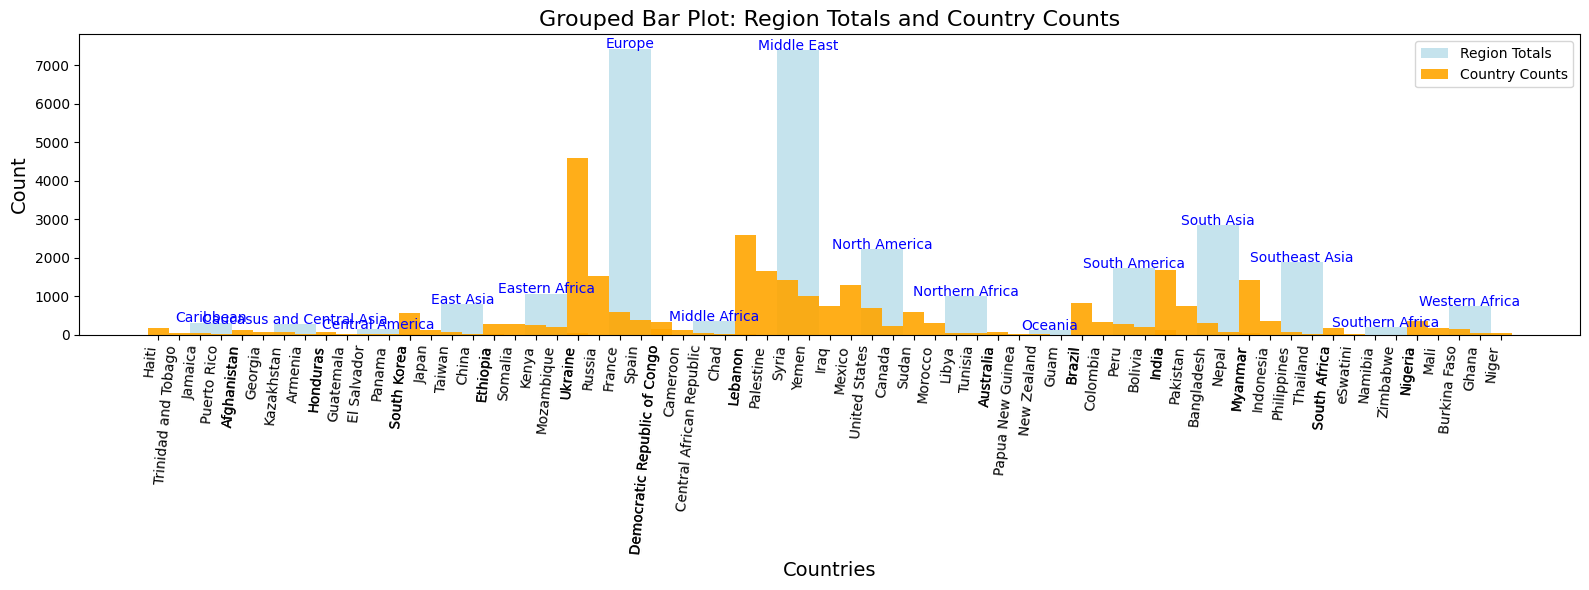

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for grouped bar plot
regions = top_5_per_region['region'].unique()  # Unique regions
bar_width = 0.50  # Width of the bars
x_indices = np.arange(len(regions))  # X positions for region bars

# Calculate total counts per region
region_totals = top_5_per_region.groupby('region')['count'].sum().values

# Initialize lists to store country-level bar data
country_offsets = []  # X positions for countries
country_labels = []  # Labels for countries
country_heights = []  # Heights for country bars (counts)

# Prepare data for country-level bars
for i, region in enumerate(regions):
    # Get countries and counts within each region
    region_data = top_5_per_region[top_5_per_region['region'] == region]
    countries_in_region = region_data['country'].values
    counts_in_region = region_data['count'].values
    
    # Calculate offsets for countries relative to region
    n_countries = len(countries_in_region)
    offsets = x_indices[i] + (np.arange(n_countries) - n_countries / 2) * (bar_width / 2)
    country_offsets.extend(offsets)
    country_labels.extend(countries_in_region)
    country_heights.extend(counts_in_region)

# Create the figure
plt.figure(figsize=(16, 6))

# Plot region totals
plt.bar(x_indices, region_totals, width=bar_width, align='center', color='lightblue', label='Region Totals', alpha=0.7)

# Plot country-level bars
plt.bar(country_offsets, country_heights, width=bar_width / 2, color='orange', label='Country Counts', alpha=0.9)

# Add region annotations above the region bars
for x, height, region in zip(x_indices, region_totals, regions):
    plt.text(x, height + 5, region, ha='center', fontsize=10, color='blue')

# Add labels and titles
plt.xlabel('Countries', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Grouped Bar Plot: Region Totals and Country Counts', fontsize=16)

# Custom x-axis labels: Only country names
plt.xticks(ticks=country_offsets, labels=country_labels, rotation=85, ha='right', fontsize=10)

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
